# Import Libraries

In [1]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import requests
import matplotlib.pyplot as plt

# Load information related to orders

In [2]:
#Load JSON file

input_file = open ('orders.json')
json_array = json.load(input_file)

In [3]:
# Flatten JSON file to create a dataframe

df= pd.json_normalize(json_array,'line_items',['total_price','created_at','id',['customer','id']],meta_prefix='order_',record_prefix='item_')
print(df.head())
print(df.dtypes)
print(df.shape)

   item_id  item_product_id item_product_sku              item_product_name  \
0   610448        632910392   PPLEPUNCH20-05  Purple Punch 2.0 Dried Flower   
1   997208        278266679       GPSTASH-01   Grandpa's Stash Dried Flower   
2   997208        278266679       GPSTASH-01   Grandpa's Stash Dried Flower   
3   759658        573794972     SAGENSOUR-01       Sage N Sour Dried Flower   
4   759658        573794972     SAGENSOUR-01       Sage N Sour Dried Flower   

   item_price order_total_price      order_created_at          order_id  \
0       29.40             79.39  2020-03-07T14:31:11Z  8369263756632563   
1       49.99             79.39  2020-03-07T14:31:11Z  8369263756632563   
2       49.99             86.98  2020-03-01T09:16:30Z  7262170348080494   
3       36.99             86.98  2020-03-01T09:16:30Z  7262170348080494   
4       36.99             36.99  2020-01-01T09:17:03Z  7722055557038194   

  order_customer.id  
0             47178  
1             47178  
2       

<b> Only used Customer ID from the customer related information as the rest of the data is not useful for the finance department to analyze sales results </b>


In [4]:
#Convert order date to datetime format and remove timestamp

#df= pd.DataFrame(order_list)
df['order_created_at'] =  pd.to_datetime(df['order_created_at'], format='%Y/%m/%d')
df['order_created_at'] = df['order_created_at'].dt.date.astype('datetime64')
print(df.dtypes)

item_id                       int64
item_product_id               int64
item_product_sku             object
item_product_name            object
item_price                  float64
order_total_price            object
order_created_at     datetime64[ns]
order_id                     object
order_customer.id            object
dtype: object


# Connect to API

In [5]:
#Test request status of API
response = requests.get("https://api.exchangeratesapi.io/latest")
print(response.status_code)


200


In [6]:
#Get exchange rate for Q1 of 2020 (From 2019-12-31 to 2020-04-30)

response1 = requests.get("https://api.exchangeratesapi.io/history?start_at=2019-12-01&end_at=2020-04-30&base=USD&symbols=CAD")
price_list = json.loads(response1.text)
#print(price_list)

In [7]:
#Convert API exchange rates to dataframe 

df2 = pd.DataFrame(price_list)
df2 = df2.reset_index()
print(df2)

          index                  rates    start_at base      end_at
0    2019-12-02  {'CAD': 1.3295835979}  2019-12-01  USD  2020-04-30
1    2019-12-03  {'CAD': 1.3320386596}  2019-12-01  USD  2020-04-30
2    2019-12-04  {'CAD': 1.3272267846}  2019-12-01  USD  2020-04-30
3    2019-12-05  {'CAD': 1.3169280692}  2019-12-01  USD  2020-04-30
4    2019-12-06  {'CAD': 1.3176491797}  2019-12-01  USD  2020-04-30
..          ...                    ...         ...  ...         ...
99   2020-04-24  {'CAD': 1.4049074074}  2019-12-01  USD  2020-04-30
100  2020-04-27  {'CAD': 1.4057316624}  2019-12-01  USD  2020-04-30
101  2020-04-28  {'CAD': 1.3955134688}  2019-12-01  USD  2020-04-30
102  2020-04-29  {'CAD': 1.3954067515}  2019-12-01  USD  2020-04-30
103  2020-04-30  {'CAD': 1.3862633321}  2019-12-01  USD  2020-04-30

[104 rows x 5 columns]


In [8]:
# Clean the rates dataframe and remove unnecssary information

df2['rates']= df2['rates'].astype(str)
df2['rates'] = df2['rates'].map(lambda x: x.lstrip("{'CAD':}").rstrip('}'))
df2['rates']= df2['rates'].astype(float)
df2 = df2.drop(columns=['start_at', 'base', 'end_at'])
df2 = df2.rename(columns={"index": "date"})

# Convert  date to datetime and prepare the dataframe for merging

df2['order_created_at'] =  pd.to_datetime(df2['date'], format='%Y/%m/%d')
df2 = df2.drop(columns=['date'])
print(df2)
print(df2.dtypes)

        rates order_created_at
0    1.329584       2019-12-02
1    1.332039       2019-12-03
2    1.327227       2019-12-04
3    1.316928       2019-12-05
4    1.317649       2019-12-06
..        ...              ...
99   1.404907       2020-04-24
100  1.405732       2020-04-27
101  1.395513       2020-04-28
102  1.395407       2020-04-29
103  1.386263       2020-04-30

[104 rows x 2 columns]
rates                      float64
order_created_at    datetime64[ns]
dtype: object


<b> Renamed the date column to the same name as the date column used in the Order information dataframe to make merging easier </b>

# Merge Order data with the correct exchange rate

In [9]:
# Create final dataframe by merging the original data with rates dataframe

final_df =pd.merge(df,df2,how = 'left', on = 'order_created_at')
final_df = final_df.sort_values('order_created_at')

In [10]:
final_df.head()

,item_id,item_product_id,item_product_sku,item_product_name,item_price,order_total_price,order_created_at,order_id,order_customer.id,rates
4,759658,573794972,SAGENSOUR-01,Sage N Sour Dried Flower,36.99,36.99,2020-01-01,7722055557038194,59933,NaN
28,771854,694165761,HYBTINC-03,Hybrid Blend THC Tincture,49.99,55.98,2020-01-01,5825547264855968,59933,NaN
29,317808,477365777,GOGPR-07,Glueberry OG Pre-Rolls,5.99,55.98,2020-01-01,5825547264855968,59933,NaN
25,997208,278266679,GPSTASH-01,Grandpa's Stash Dried Flower,49.99,55.98,2020-01-05,6255086600405590,94720,NaN
26,317808,477365777,GOGPR-07,Glueberry OG Pre-Rolls,5.99,55.98,2020-01-05,6255086600405590,94720,NaN


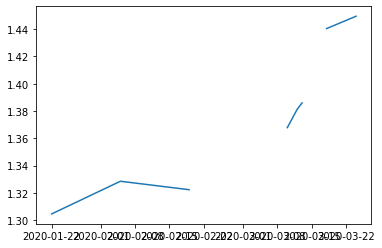

In [11]:
# Without imputing rates 

plt.figure()

x = final_df['order_created_at']
y1 = final_df['rates']


plt.plot(x,y1)


In [12]:
# Imput based on forward and backward fill.  Limits were decided based on trial and error to ensure that all orders placed on the same day have the same rate.

final_df = final_df.fillna(method='ffill', limit=2)
final_df = final_df.fillna(method='bfill', limit=7)

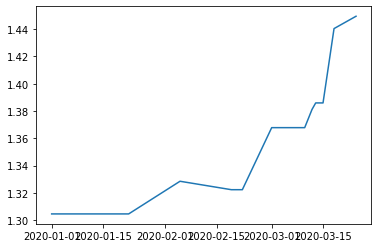

In [13]:
# After filling missing rates

plt.figure()

x = final_df['order_created_at']
y1 = final_df['rates']


plt.plot(x,y1)


In [14]:
final_df.isna

<bound method DataFrame.isna of     item_id  item_product_id item_product_sku              item_product_name  \
4    759658        573794972     SAGENSOUR-01       Sage N Sour Dried Flower   
28   771854        694165761       HYBTINC-03      Hybrid Blend THC Tincture   
29   317808        477365777         GOGPR-07         Glueberry OG Pre-Rolls   
25   997208        278266679       GPSTASH-01   Grandpa's Stash Dried Flower   
26   317808        477365777         GOGPR-07         Glueberry OG Pre-Rolls   
22   604665        510650809            PAX-3                Pax 3 Vaporizer   
30   610448        632910392   PPLEPUNCH20-05  Purple Punch 2.0 Dried Flower   
36   771854        694165761       HYBTINC-03      Hybrid Blend THC Tincture   
33   997208        278266679       GPSTASH-01   Grandpa's Stash Dried Flower   
34   759658        573794972     SAGENSOUR-01       Sage N Sour Dried Flower   
35   317808        477365777         GOGPR-07         Glueberry OG Pre-Rolls   
21   317

In [15]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 4 to 27
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   item_id            37 non-null     int64         
 1   item_product_id    37 non-null     int64         
 2   item_product_sku   37 non-null     object        
 3   item_product_name  37 non-null     object        
 4   item_price         37 non-null     float64       
 5   order_total_price  37 non-null     float64       
 6   order_created_at   37 non-null     datetime64[ns]
 7   order_id           37 non-null     int64         
 8   order_customer.id  37 non-null     int64         
 9   rates              37 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 3.2+ KB


<b> Initially there were 17 null values for rates, that were not available based on the API date. The days when rates are missing are most likely due to weekends or bank holidays as such the best and most realistic option would be to get the closing price of the previous day. However, since order dates are spread out it would not make sense to fill all the missing rates by the last reported value. That is the reasoning behind using both the forward and backward fill method; to ensure that the rate is depicted as realistically as possible. </b>

# Create final dataframe for export

In [16]:
#Create a new column to have the order price in CAD and make date as index

final_df['item_price_CAD'] = final_df['item_price'] * final_df['rates']
final_df['total_CAD'] = final_df['order_total_price'] * final_df['rates']
final_df = final_df.set_index('order_created_at')

In [17]:
final_df = final_df.drop(columns=['item_price', 'order_total_price'])

In [23]:
final_df[final_df['item_product_name'] == 'Pax 3 Vaporizer']

,item_id,item_product_id,item_product_sku,item_product_name,order_id,order_customer.id,rates,item_price_CAD,total_CAD
order_created_at,,,,,,,,,
2020-01-18,604665,510650809,PAX-3,Pax 3 Vaporizer,2366621613260728,23955,1.304563,339.173462,339.173462
2020-03-12,604665,510650809,PAX-3,Pax 3 Vaporizer,6431399815998774,23955,1.381139,359.082274,436.398423
2020-03-13,604665,510650809,PAX-3,Pax 3 Vaporizer,2249838395290890,47178,1.385897,360.319354,429.600344
2020-03-15,604665,510650809,PAX-3,Pax 3 Vaporizer,5058732129957127,59933,1.385897,360.319354,429.600344


# Sanity Check

In [18]:
df[df['order_created_at'].dt.date.astype(str) == '2020-02-19']

,item_id,item_product_id,item_product_sku,item_product_name,item_price,order_total_price,order_created_at,order_id,order_customer.id
13,317808,477365777,GOGPR-07,Glueberry OG Pre-Rolls,5.99,55.98,2020-02-19,2079640804901496,23955
14,771854,694165761,HYBTINC-03,Hybrid Blend THC Tincture,49.99,55.98,2020-02-19,2079640804901496,23955


In [19]:
df2[df2['order_created_at'].dt.date.astype(str) == '2020-02-19']

,rates,order_created_at
54,1.322315,2020-02-19


In [20]:
final_df.loc['2020-02-15':'2020-02-20']

,item_id,item_product_id,item_product_sku,item_product_name,order_id,order_customer.id,rates,item_price_CAD,total_CAD
order_created_at,,,,,,,,,
2020-02-19,317808,477365777,GOGPR-07,Glueberry OG Pre-Rolls,2079640804901496,23955,1.322315,7.920666,74.023183
2020-02-19,771854,694165761,HYBTINC-03,Hybrid Blend THC Tincture,2079640804901496,23955,1.322315,66.102518,74.023183


<b> The above code was purely to ensure that the merge was completed succesfully, it will show how the correct rate was matched to the appropriate date </b>

<b> The final dataset is indexed based on the order date, therefore it is important to note that there will be multiple lines for a single order. </b>

# Export to CSV

In [21]:
final_df.to_csv(r'C:\Users\irind\Desktop\NamasteTechnologies_DataChallenge\task1.csv')